notebook 3
- ~~podział na kilka zbiorów - timeseries split 1msc val 2msc test x3~~
- model baseline który daje następny dzień jako predykcję
- podzbiory kolumn
- użycie propheta + tłumaczenie dlaczego na 2 zapisie - jak użyliśmy na zerach to słabo wyszło na poniedziałkowej predykcji
- wzięcie jego predykcji i zapis
- funkcje do fancy metryk jako df dla 3 okresów train test val


### Importy

In [5]:
import pandas as pd
import numpy as np
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *
from prophet import Prophet

In [6]:
prefix = "NFLX"

In [8]:
train_set = pd.read_csv("csv/"+prefix+'/train_set.csv')
test_set = pd.read_csv("csv/"+prefix+'/test_set.csv')

In [11]:
df_with_weekends = pd.read_csv("csv/"+prefix+'_with_weekends.csv')

### Baseline

### Prophet

In [52]:
df_with_weekends['y_diff'] = df_with_weekends[prefix+'_Close'].shift(-1) - df_with_weekends[prefix+'_Close']

In [9]:
train_set.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'future', 'influential', 'trustworthy',
       'not clickbait', 'finbert_Score', 'bart_Score', 'vader_Score',
       'future_finbert', 'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', '^GSPC_Close',
       '^GSPC_Volume', 'EURUSD=X_Close', 'NFLX_Open', 'NFLX_High', 'NFLX_Low',
       'NFLX_Close', 'NFLX_Volume', 'mean_future', 'mean_influential',
       'mean_trustworthy', 'mean_clickbait', 'sma_50', 'ema_20', 'rsi_14',
       'slowk', 'vwap', 'roc_14', 'Daily_Variation', 'High_Close_Pressure',
       'Low_Open_Pressure', 'Year', 'target_1', 'target_5', 'target_10',
       'target_20', 'target_1_std', 'target_5_std', 'target_10_std',
       'target_20_std'],
      dtype='object')

In [10]:
cols_r = ['sma_50', 'ema_20', 'rsi_14',
       'slowk', 'vwap', 'roc_14']
cols_t = ['target_1', 'target_5', 'target_10',
       'target_20', 'target_1_std', 'target_5_std', 'target_10_std',
       'target_20_std']
cols_n = ['finbert_Score','clickbait_finbert','influential_finbert']

In [53]:
df_with_weekends['target_1'] = df_with_weekends[prefix+'_Close'].shift(-1)
df_with_weekends['target_5'] = df_with_weekends[prefix+'_Close'].shift(-5)
df_with_weekends['target_10'] = df_with_weekends[prefix+'_Close'].shift(-10)

In [54]:
train_set, val_set, test_set = split_data(df_with_weekends, 'Date', '2023-08-01', '2023-10-01', start_date_train = '2021-01-01')
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(942, 46)
(61, 46)
(55, 46)


In [116]:
cols = cols_r+cols_n

In [117]:
target = "y_diff"
train_prophet = train_set[cols+[target,'Date']].rename(columns={"Date":"ds",target:"y"}) 
test_prophet = test_set[cols+[target,'Date']].rename(columns={"Date":"ds",target:"y"}) 
val_prophet = val_set[cols+[target,'Date']].rename(columns={"Date":"ds",target:"y"}) 

m = Prophet()
for col in cols:
  m.add_regressor(col)

m.fit(train_prophet)

forecast_test = m.predict(test_prophet)
forecast_val = m.predict(val_prophet)
forecast_train = m.predict(train_prophet)


18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
train_pred = forecast_train['yhat']            
test_pred =  forecast_test['yhat'][:-1]       
val_pred =  forecast_val['yhat']

In [121]:
count_signs_matrix(test_set[target][:-1], test_pred)

array([[23,  0],
       [16,  0]])

In [119]:
calculate_metrics(train_set[target].to_numpy(), forecast_train['yhat'].to_numpy(), 
                  test_set[target][:-1].to_numpy(), forecast_test['yhat'][:-1].to_numpy(), 
                  val_set[target].to_numpy(), forecast_val['yhat'].to_numpy()
                    )

c:\Users\HP\Documents\INZ\LBN-INZ\CODE\model_training\scripts\plots.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


,MAE,MSE,RMSE,R2 Score,MAPE,MASE
Train,5.639294,94.661338,9.729406,0.050049,inf,0.692639
Test,6.052273,86.967429,9.325633,-0.067879,inf,0.743362
Validation,6.027348,63.852222,7.990759,-0.515575,inf,0.740301


In [93]:
target = 'y_diff'
train_y = train_set[target]
test_y = test_set[target][:-1]
val_y = val_set[target]

In [57]:
train_y = train_set[target].to_numpy()
test_y = test_set[target][:-1].to_numpy()
val_y = val_set[target].to_numpy()

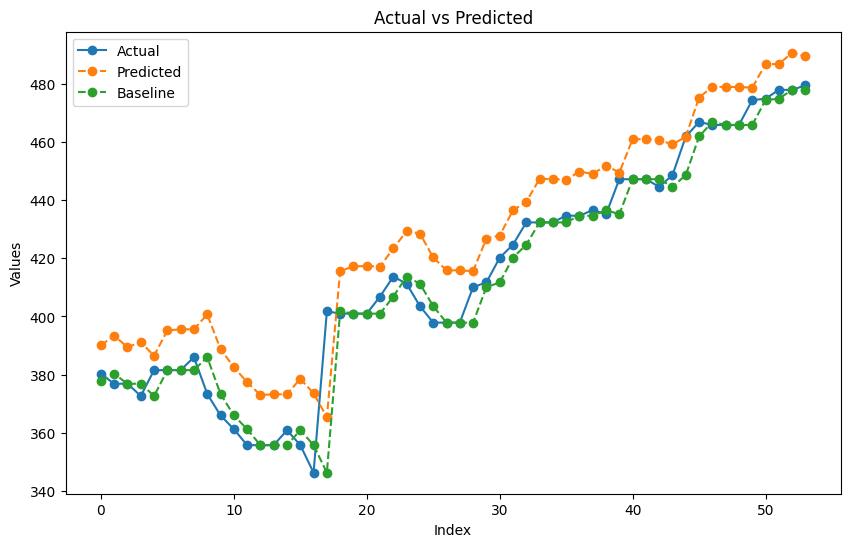

In [47]:
plot_actual_vs_predicted(test_set[[target]][:-1].to_numpy(),forecast_test[['yhat']][:-1].to_numpy(),
                         test_set[[prefix+'_Close']][:-1].to_numpy())